# Gen - part 1: Introduction to Modeling in Gen

In [ ]:
import Pkg
Pkg.add("Gen")
using Gen

In [ ]:
Pkg.add("Plots")
using Plots

In [ ]:
import ..GenExerciseUtils

## Part 1: Basics of Modeling

### Exercise 1:

Write a generative function that uses the same address twice. Run it to see what happens.

In [321]:
@gen function line_model(xs::Vector{Float64})

    b = ({:b} ~ normal(0, 1))

    # We define a function to compute y for a given x
    function y(x)
        return b * x + b
    end


    for (i, x) in enumerate(xs)

        ({(:y, i)} ~ normal(y(x), 0.1))
    end

    return y
end;

In [322]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];

In [323]:
y = line_model(xs)

y (generic function with 1 method)

In [324]:
trace = Gen.simulate(line_model, (xs,));

In [325]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##line_model#708", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:b => Gen.ChoiceOrCallRecord{Float64}(-1.0563399077583315, -1.4768655335661127, NaN, true), (:y, 11) => Gen.ChoiceOrCallRecord{Float64}(-6.325970787395859, 1.3763639331004427, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(2.0985342793525055, 1.3736417501207983, NaN, true), (:y, 1) => Gen.ChoiceOrCallRecord{Float64}(4.236499983063854, 1.377441187621169, NaN, true), (:y, 8) => Gen.ChoiceOrCallRecord{Float64}(-3.0893594465112795, 1.0663585750857882, NaN, true), (:y, 7) => Gen.ChoiceOrCallRecord{Float64}(-2.138698140095808, 1.3497988990940857, NaN, true), (:y, 5) => Gen.ChoiceOrCallRecord{Float64}(-0.20860170712504855, -0.7920870509848537, NaN, true), (:y, 6) => Gen.ChoiceOrCallRecord{Float64}(-1.0581

In [326]:
Gen.get_args(trace)

([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)

In [327]:
Gen.get_choices(trace)

│
├── :b : -1.0563399077583315
│
├── (:y, 11) : -6.325970787395859
│
├── (:y, 3) : 2.0985342793525055
│
├── (:y, 1) : 4.236499983063854
│
├── (:y, 8) : -3.0893594465112795
│
├── (:y, 7) : -2.138698140095808
│
├── (:y, 5) : -0.20860170712504855
│
├── (:y, 6) : -1.0581800078368246
│
├── (:y, 10) : -5.019470959880492
│
├── (:y, 4) : 0.9508399929866234
│
├── (:y, 2) : 3.329284071992979
│
└── (:y, 9) : -4.365845432162628


In [328]:
choices = Gen.get_choices(trace)
choices[:b]

-1.0563399077583315

In [329]:
Gen.get_retval(trace)

y (generic function with 1 method)

In [330]:
trace[]

y (generic function with 1 method)

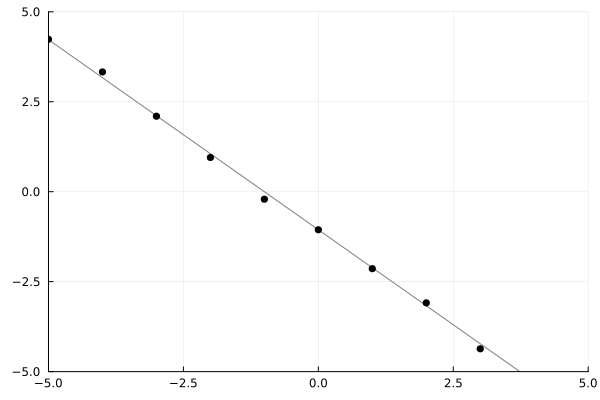

In [331]:
render_trace(trace)

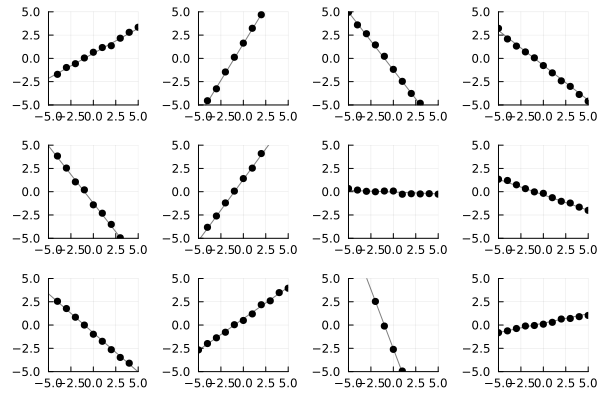

In [332]:
traces = [Gen.simulate(line_model, (xs,)) for _=1:12]
grid(render_trace, traces)

### Exercise 2

Write a generative function model that generates a sine wave with random phase, period, and amplitude, and then generates y-coordinates from a given vector of x-coordinates by adding noise to the value of the wave at each x-coordinate. Use a gamma(1, 1) prior distribution for the period and a gamma(1, 1) prior distribution on the amplitude. Sampling from a Gamma distribution will ensure positive real values. Use a uniform distribution between 0 and 2π for the phase.

The sine wave function should implement:

$$y(x) = \alpha * sin(2πx / \rho+ \phi)$$

where $\alpha$ is the amplitude, $\rho$ is the period, and $\phi$ is the phase. In Julia, the constant can be expressed as either `pi` or `π` (unicode).

When calling `trace = Gen.simulate(sine_model, (xs,))`, the following choices should appear:

- Amplitude: `trace[:amplitude]`
- Period: `trace[:period]`
- Phase: `trace[:phase]`

In [333]:
@gen function sine_model(xs::Vector{Float64})

    phase = ({:phase} ~ uniform(0, 2pi))
    period = ({:period} ~ gamma(1, 1))
    amplitude = ({:amplitude} ~ gamma(1, 1))

    function y(x)
        return amplitude * sin(2pi*x / period + phase)
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), 0.1)
    end

    return y
end;

In [334]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];

In [335]:
traces = [Gen.simulate(sine_model, (xs,)) for _=1:12];

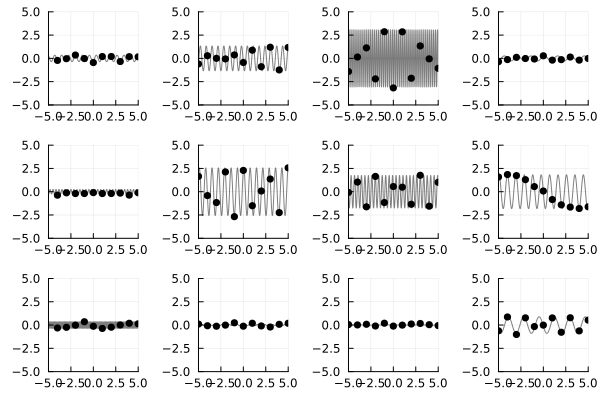

In [336]:
grid(render_trace, traces)

### Exercise 3

The results of Bayesian Linear Regression Using Importnce Sampling in the Tutorial were obtained for amount_of_computation = 100. Run the algorithm with this value set to 1, 10, and 1000, etc. Which value seems like a good tradeoff between accuracy and running time? Discuss.

Amount of computation:1


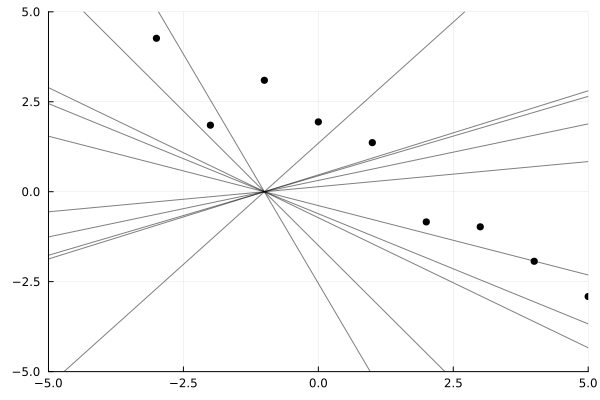

Amount of computation:10


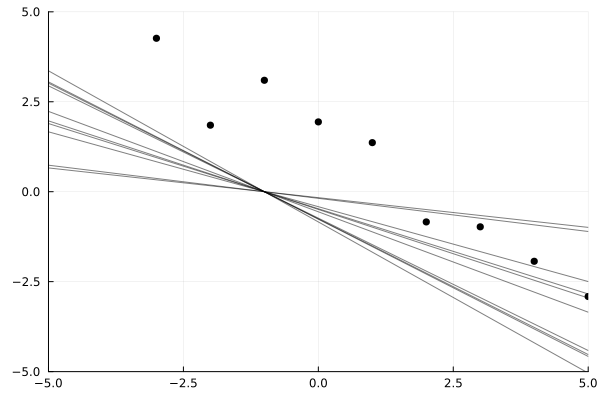

Amount of computation:1000


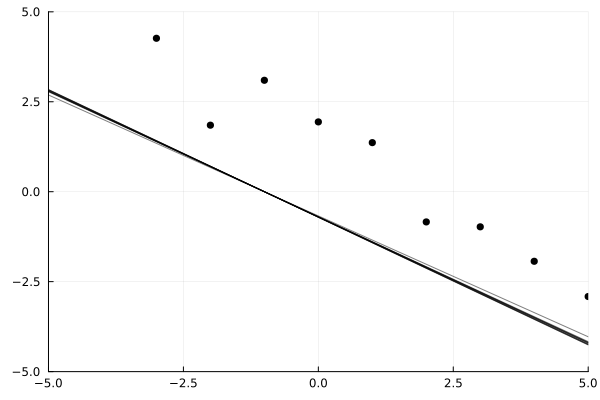

In [337]:
for i in [1, 10, 1000]
    traces = [do_inference(line_model, xs, ys, i) for _=1:10]
    println("Amount of computation:", i)
    display(overlay(render_trace, traces))
end

We observe a more 'confident' prediction from our model for higher amounts of computation. I believe the amount_of_computation parameter indicates the number of times the model will be executed or the number of particles used in the importance resampling algorithm.

### Exercise 4

Consider the following data set.

- ys_sine = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];
- scatter(xs, ys_sine, color="black", label=nothing)

Write an inference program that generates traces of sine_model that explain this data set. Visualize the resulting distribution of traces. Temporarily change the prior distribution on the period to be gamma(1, 1) (by changing and re-running the cell that defines sine_model from a previous exercise). Can you explain the difference in inference results when using gamma(1, 1) vs gamma(5, 1) prior on the period? How much computation did you need to get good results?

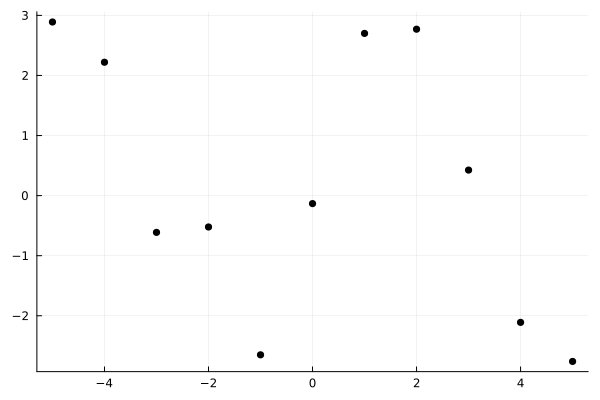

In [338]:
ys_sine = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];
scatter(xs, ys_sine, color="black", label=nothing)

In [339]:
@gen function sine_model(xs::Vector{Float64})

    phase = ({:phase} ~ uniform(0, 2pi))
    period = ({:period} ~ gamma(5, 1))
    amplitude = ({:amplitude} ~ gamma(1, 1))

    function y(x)
        return amplitude * sin(2pi*x / period + phase)
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), 0.1)
    end

    return y
end;


@gen function sine_model2(xs::Vector{Float64})

    phase = ({:phase} ~ uniform(0, 2pi))
    period = ({:period} ~ gamma(1, 1))
    amplitude = ({:amplitude} ~ gamma(1, 1))

    function y(x)
        return amplitude * sin(2pi*x / period + phase)
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), 0.1)
    end

    return y
end;

When the Prior of Period is Gamma(5, 1) and Amount of computation is 20:


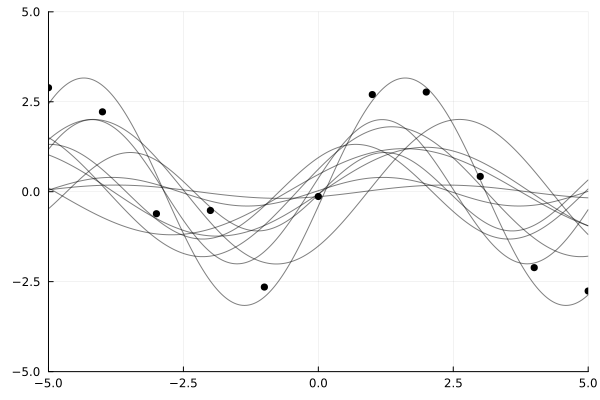

When the Prior of Period is Gamma(5, 1) and Amount of computation is 100:


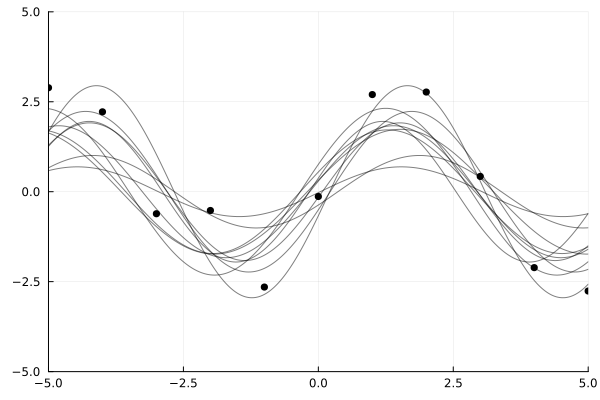

When the Prior of Period is Gamma(5, 1) and Amount of computation is 500:


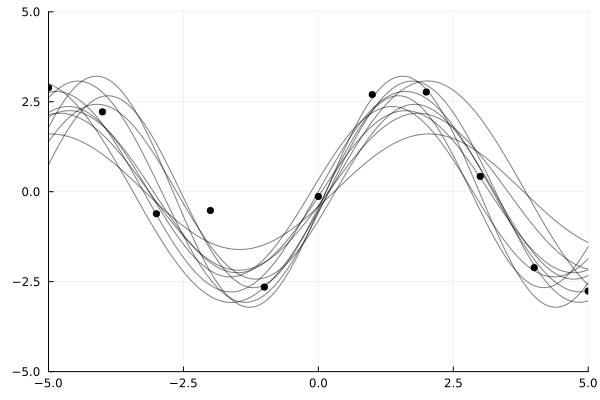

When the Prior of Period is Gamma(5, 1) and Amount of computation is 1000:


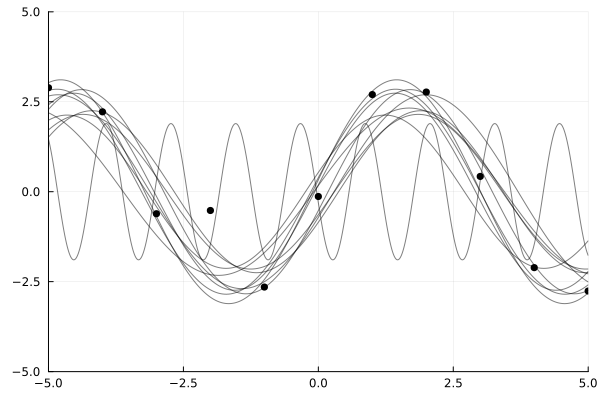

When the Prior of Period is Gamma(1, 1) and Amount of computation is 20:


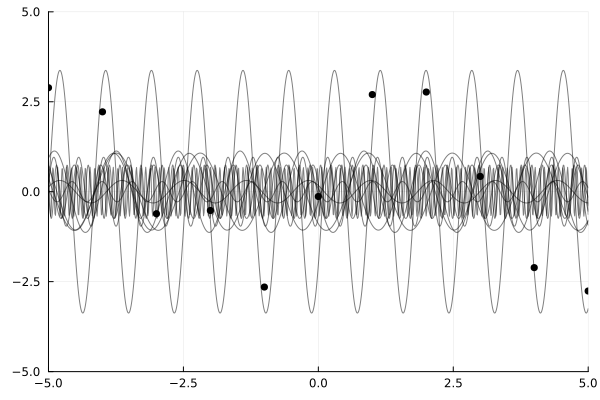

When the Prior of Period is Gamma(1, 1) and Amount of computation is 100:


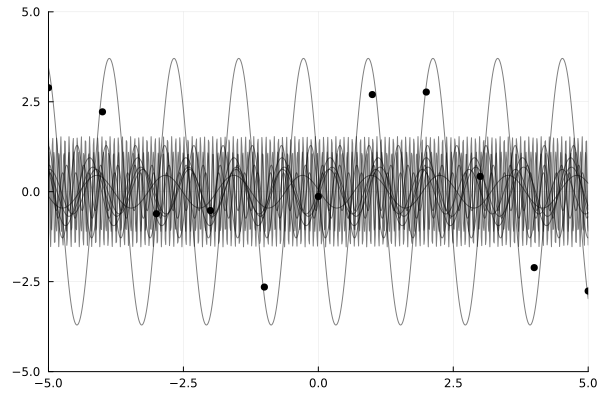

When the Prior of Period is Gamma(1, 1) and Amount of computation is 500:


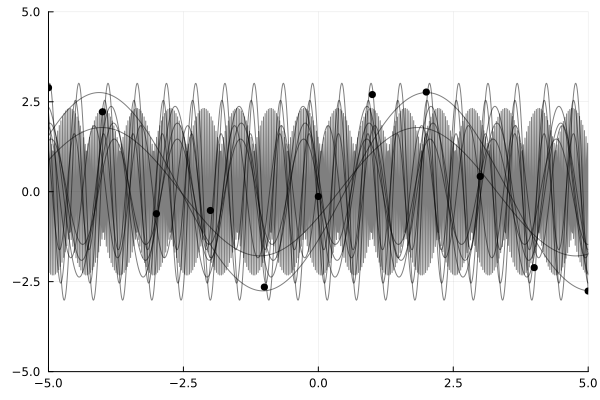

When the Prior of Period is Gamma(1, 1) and Amount of computation is 1000:


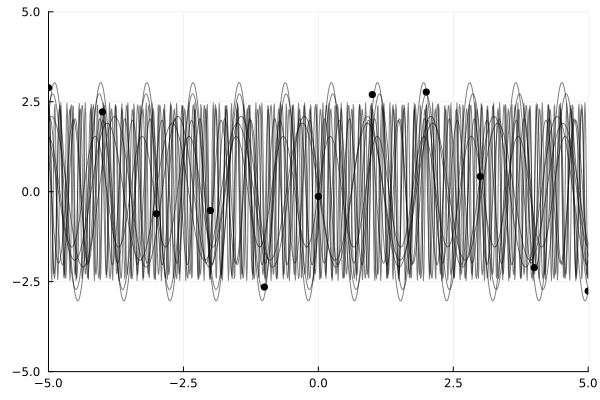

In [340]:
function plot_Ex4(model , comp, pr)
    for i in comp
        traces = [do_inference(model, xs, ys_sine, i) for _=1:10]
        println("When the Prior of Period is ", pr, " and Amount of computation is ", i, ":")
        display(overlay(render_trace, traces))
    end
end
plot_Ex4(sine_model , [20, 100, 500, 1000], "Gamma(5, 1)")
plot_Ex4(sine_model2 , [20, 100, 500, 1000], "Gamma(1, 1)")


We can observe that our model has a very difficult time getting a suitable result for Gamma(1, 1) compared to the nice result from the Gamma(5, 1) model. This is because we are using a wider prior in the second case, giving more flexibility to the model. But Gamma(1, 1) makes taking suitable samples much harder.

### Exercise 5

Write a modified version of the sine model that makes noise into a random choice. Compare the predicted data with the observed data using infer_and_predict and plot_predictions for the unmodified and modified models, and for the ys_sine and ys_noisy data sets. Discuss the results. Experiment with the amount of inference computation used. The amount of inference computation will need to be higher for the model with the noise as a random choice.

In [341]:
@gen function sine_model_fancy(xs::Vector{Float64})

    phase = ({:phase} ~ uniform(0, 2pi))
    period = ({:period} ~ gamma(5, 1))
    amplitude = ({:amplitude} ~ gamma(1, 1))

    function y(x)
        return amplitude * sin(2pi*x / period + phase)
    end


    noise = ({:noise} ~ gamma(1, 1))
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), noise)
    end

    return y
end;

In [342]:
function compare_fixed_notfixed(model_fixed, model_notfixed, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)

    pred_ys = infer_and_predict(model_fixed, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    fixed_noise_plot = plot_predictions(xs, ys_sine, new_xs, pred_ys; title="Fixed noise level")

    pred_ys = infer_and_predict(model_notfixed, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    inferred_noise_plot = plot_predictions(xs, ys_sine, new_xs, pred_ys; title="Inferred noise level")

    Plots.plot(fixed_noise_plot, inferred_noise_plot)
end

compare_fixed_notfixed (generic function with 1 method)

amount of computation = 100:


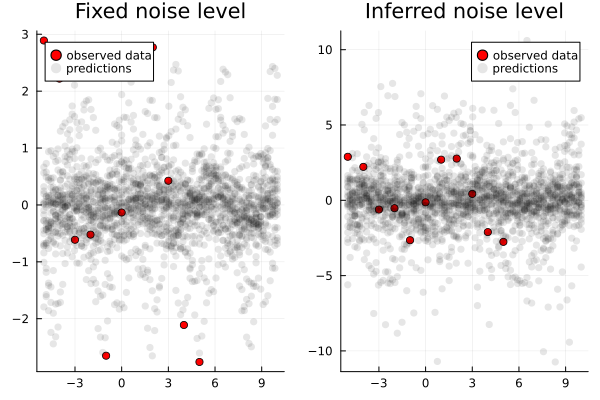

amount of computation = 500:


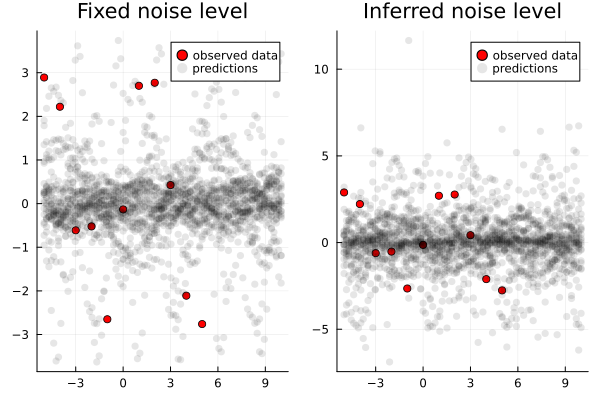

amount of computation = 1000:


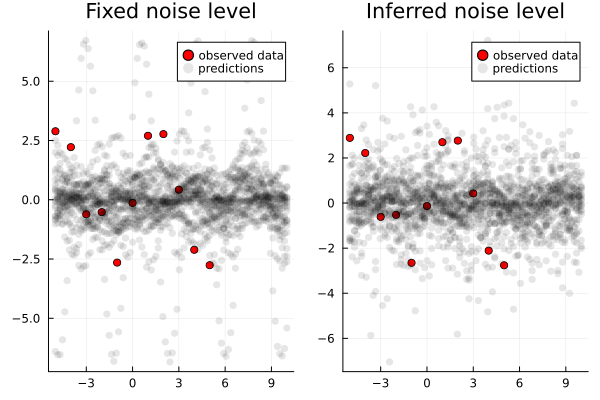

In [343]:
for i in [100, 500, 1000]
      println("amount of computation = ", i, ":")
      display(compare_fixed_notfixed(sine_model, sine_model_fancy, xs, ys_sine, new_xs, [], 20, i))
end

amount of computation = 100:


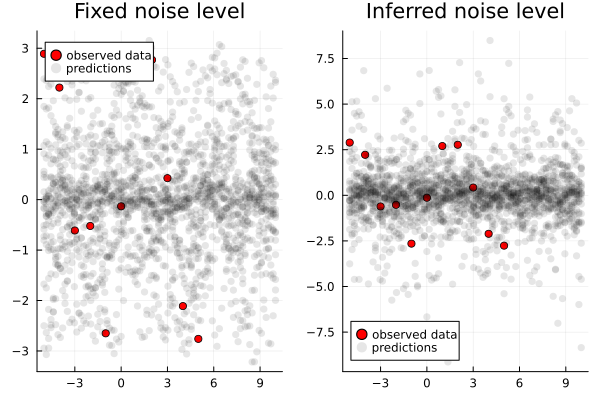

amount of computation = 500:


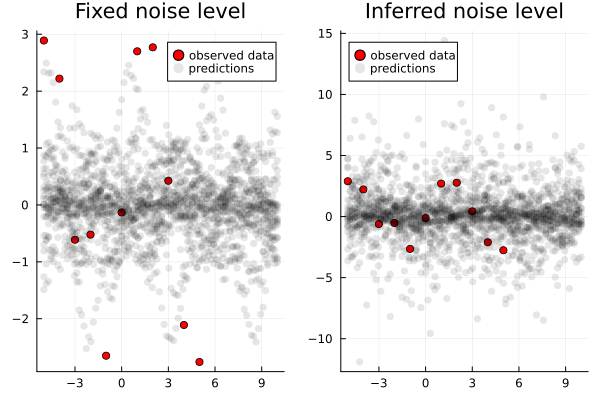

amount of computation = 1000:


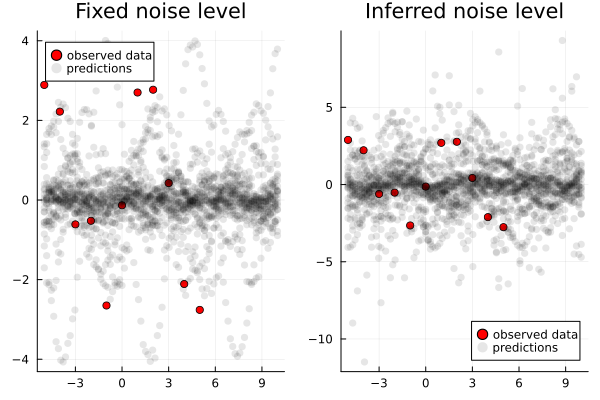

In [344]:
for i in [100, 500, 1000]
      println("amount of computation = ", i, ":")
      display(compare_fixed_notfixed(sine_model, sine_model_fancy, xs, ys_noisy, new_xs, [], 20, i))
end

### Exercise 6

Construct a data set for which it is ambiguous whether the line or sine wave model is best. Visualize the inferred traces using render_combined to illustrate the ambiguity. Write a program that takes the data set and returns an estimate of the posterior probability that the data was generated by the sine wave model, and run it on your data set.

Hint: To estimate the posterior probability that the data was generated by the sine wave model, run the inference program many times to compute a large number of traces, and then compute the fraction of those traces in which :is_line is false.

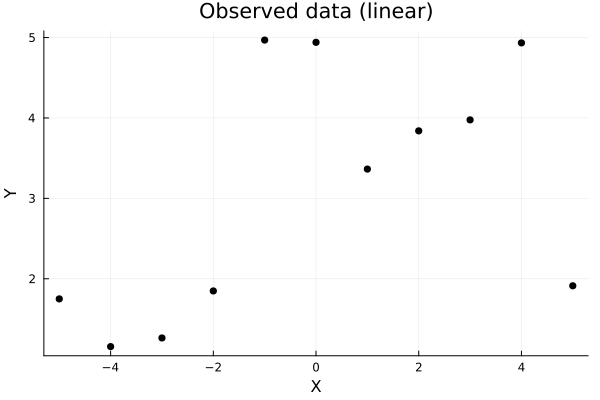

In [345]:
ys_vague = [1.75003, 1.1568, 1.26414, 1.84894, 4.9686, 4.94026, 3.36411, 3.83959, 3.976, 4.93363, 1.91303]
scatter(xs, ys_vague, color="black", label=nothing, title="Observed data (linear)", xlabel="X", ylabel="Y")

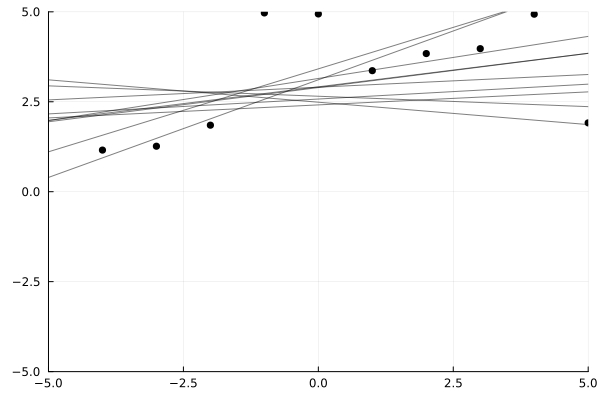

In [346]:
@gen function combined_model(xs::Vector{Float64})
    if ({:is_line} ~ bernoulli(0.5))

        return ({*} ~ line_model_fancy(xs))
    else

        return ({*} ~ sine_model_fancy(xs))
    end
end;

# Unfortunately, I wasn't able to use render_combined as instructed. render_trace seemed to work fine and render_combined gave errors. I will try to solve the problem later on.

traces = [do_inference(combined_model, xs, ys_vague, 10000) for _=1:10];
overlay(render_trace, traces)

In [347]:
is_line_false = 0

for _=1:100
    is_line_false += !do_inference(combined_model, xs, ys_vague, 100)[:is_line] ? 1 : 0
end

println("posterior probability that the data generated by the sine wave model is $(is_line_false/100)")

posterior probability that the data generated by the sine wave model is 0.06


### Exercise 7

Write a function that takes a data set of x- and y-coordinates and plots the histogram of the probability distribution on the number of changepoints. Show the results for the ys_simple and ys_complex data sets.

Hint: The return value of changepoint_model is the tree of Node values. Walk this tree.



In [ ]:
# this bayesian nonparametric model was taken from the Gen tutorial
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if ({:isleaf} ~ bernoulli(0.7))
        value = ({:value} ~ normal(0, 1))
        return LeafNode(value, interval)
    else
        frac = ({:frac} ~ beta(2, 2))
        mid  = l + (u - l) * frac
        left = ({:left} ~ generate_segments(l, mid))
        right = ({:right} ~ generate_segments(mid, u))
        return InternalNode(left, right, interval)
    end
end;

In [348]:
function count_changepoints(node::InternalNode)
    return 1 + count_changepoints(node.left) + count_changepoints(node.right)
end

function count_changepoints(node::LeafNode)
    return 0
end

function count_changepoints(tree::Node)
    return count_changepoints(tree)
end

count_changepoints (generic function with 3 methods)

In [349]:
function plot_changepoint_histogram(data_xs, data_ys)
    num_changepoints = []

    # Simulate the model multiple times to obtain a distribution of changepoints
    for _ in 1:1000
        trace = Gen.simulate(changepoint_model, (data_xs,))
        node = Gen.get_retval(trace)
        push!(num_changepoints, count_changepoints(node))
    end

    # Plot the histogram
    histogram(num_changepoints, xlabel="Number of Changepoints", ylabel="Frequency",
               title="Histogram of Changepoints", legend=false)
end

plot_changepoint_histogram (generic function with 1 method)

In [350]:
xs_dense = collect(range(-5, stop=5, length=50))
ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;

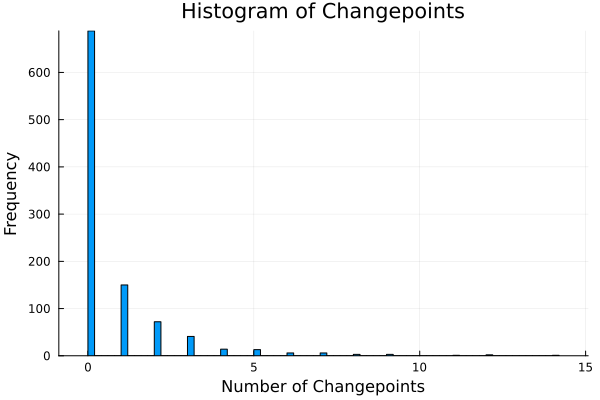

In [351]:
plot_changepoint_histogram(xs_dense, ys_simple)

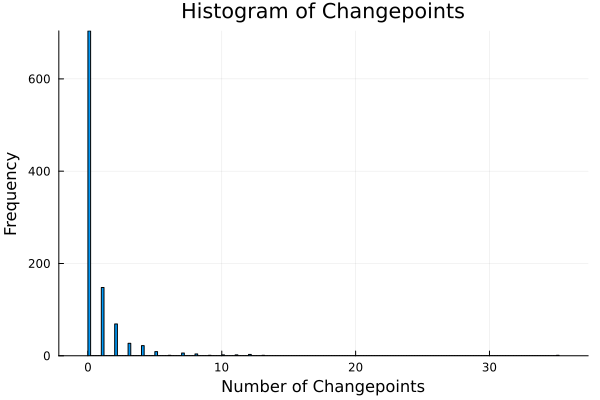

In [352]:
plot_changepoint_histogram(xs_dense, ys_complex)

### Exercise 8

Write a new version of changepoint_model that uses {*} ~ ... without an address to make the recursive calls.

Hint: You will need to guarantee that all addresses are unique. How can you label each node in a binary tree using an integer?

***Incomplete section***

In [353]:
# Add a unique id value

struct InternalNodeid <: Node
    left::Node
    right::Node
    interval::Interval
    id::Int
end

InternalNodeit(i::InternalNodeid) = InternalNode(i.left, i.right, i.interval)

struct LeafNodeid <: Node
    value::Float64
    interval::Interval
    id::Int
end

LeafNodeit(i::LeafNodeid) = LeafNode(i.value, i.interval)


LeafNodeit (generic function with 1 method)

In [354]:
@gen function generate_segments(l::Float64, u::Float64, id::Int64)
    interval = Interval(l, u)
    if ({:b} ~ bernoulli(0.7))
        value = ({:v} ~ normal(0, 1))
        id = id+1
        return LeafNodeid(value, interval, id)
    else
        frac = ({:f} ~ beta(2, 2))
        mid  = l + (u - l) * frac
        id = id+1
        left = ({:l} ~ generate_segments(l, mid, id))
        right = ({:r} ~ generate_segments(mid, u, id))
        return InternalNodeid(left, right, interval, id)
    end
end;

In [355]:
function render_node!(node::LeafNode)
    plot!([node.interval.l, node.interval.u], [node.value, node.value], label=nothing, linewidth=5)
end


function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;


function render_segments_trace(trace; xlim=(0,1))
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=(-3, 3))
    render_node!(node)
    return fig
end;

In [356]:
# Generate traces using the simulate function
traces = [Gen.simulate(generate_segments, (0., 1., 0)) for i=1:12]

# Visualize the generated traces
grid(render_segments_trace, traces)